# Análisis de Datos del Titanic
Este notebook replica el flujo del notebook de Spotify aplicado al dataset `titanic.csv`.
Se enfatiza el análisis: cajas y bigotes, boxplots por categoría, correlaciones, scatter plots con línea de tendencia y mapas de calor.

Usaremos Pandas, Seaborn y Matplotlib. Después de cada visualización hay interpretación y conclusiones cortas.

# Análisis de Datos del Titanic
Notebook adaptado del estilo del profesor. Se incluyen visualizaciones y explicaciones interpretativas después de cada gráfico.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
sns.set(style="whitegrid")
%matplotlib inline
## Clustering: k-means (actividad nueva)
En esta sección aplicamos k-means para encontrar patrones no supervisados en el dataset. Se muestran decisiones de selección de variables, elección de k y análisis de centros.

In [48]:
# Selección de variables para clustering (solo numéricas relevantes)
# Justificación: Excluimos identificadores y la variable objetivo 'Survived' para no filtrar el clustering; columnas categóricas como Name, Ticket, Cabin no aportan directamente como numéricas.
features = ['Pclass','Age','SibSp','Parch','Fare']
print('Features usadas:', features)
# Construir dataframe con las features seleccionadas
df_cluster = df_clean[features].copy()
print('Shape (antes de imputar):', df_cluster.shape)
print('Valores nulos por columna (antes):')
print(df_cluster.isna().sum().to_dict())
# Imputación sencilla por mediana (evita eliminar demasiadas filas); se podría imputar por Pclass/Sex posteriormente
for c in features:
    if df_cluster[c].isna().sum() > 0:
        df_cluster[c].fillna(df_cluster[c].median(), inplace=True)
print('Valores nulos por columna (después de median imputation):')
print(df_cluster.isna().sum().to_dict())
display(df_cluster.describe())

Features usadas: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Shape (antes de imputar): (891, 5)
Valores nulos por columna (antes):
{'Pclass': 0, 'Age': 177, 'SibSp': 0, 'Parch': 0, 'Fare': 0}
Valores nulos por columna (después de median imputation):
{'Pclass': 0, 'Age': 0, 'SibSp': 0, 'Parch': 0, 'Fare': 0}


,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.836071,13.019697,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,35.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


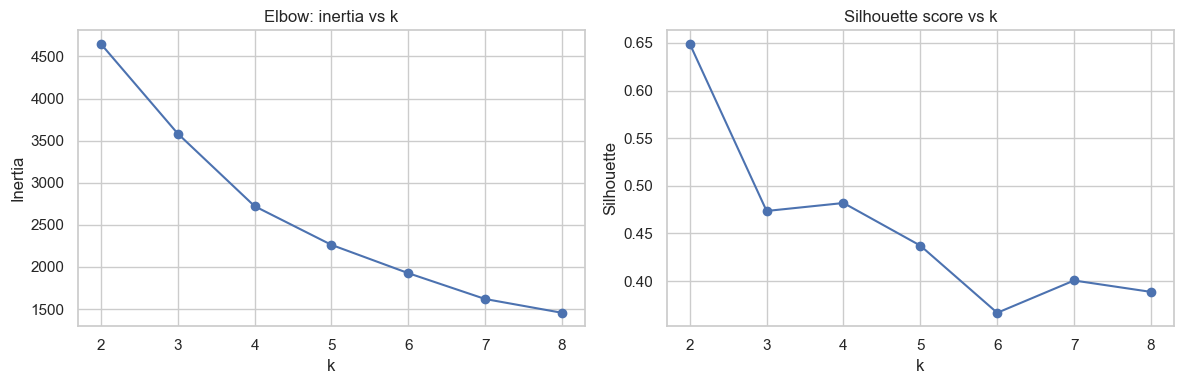

k elegido por silhouette: 2
Silhouette por k: {2: 0.649073648826508, 3: 0.473578794342411, 4: 0.4819473950143941, 5: 0.43720821484583505, 6: 0.3666941345012402, 7: 0.4006071790862432, 8: 0.38864442509361097}


In [49]:
# Escalado robusto para reducir efecto de outliers
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
scaler = RobustScaler()
X = scaler.fit_transform(df_cluster)
# Evaluar k con inertia (elbow) y silhouette
Ks = range(2,9)
inertias = []
silhouettes = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    try:
        silhouettes.append(silhouette_score(X, labels))
    except Exception:
        silhouettes.append(np.nan)
# Plots
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(list(Ks), inertias, '-o')
plt.xlabel('k'); plt.ylabel('Inertia'); plt.title('Elbow: inertia vs k')
plt.subplot(1,2,2)
plt.plot(list(Ks), silhouettes, '-o')
plt.xlabel('k'); plt.ylabel('Silhouette'); plt.title('Silhouette score vs k')
plt.tight_layout()
plt.show()
# Elegir k: usamos el k con mayor silhouette score como criterio objetivo (balance compactness/cohesión)
best_k = list(Ks)[int(np.nanargmax(silhouettes))]
print('k elegido por silhouette:', best_k)
print('Silhouette por k:', dict(zip(list(Ks), silhouettes)))

In [50]:
# Ajustar KMeans con k elegido y calcular centros en la escala original
km = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X)
centers_scaled = km.cluster_centers_
centers = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers, columns=features)
centers_df.index.name = 'cluster'
display(centers_df)
print('Tamaño de cada cluster:')
print(dict(enumerate(np.bincount(km.labels_))))

,Pclass,Age,SibSp,Parch,Fare
cluster,,,,,
0,2.391408,29.221062,0.514320,0.349642,22.411942
1,1.000000,31.583396,0.660377,0.886792,187.032858


Tamaño de cada cluster:
{0: np.int64(838), 1: np.int64(53)}


In [51]:
# Distancias entre centros (euclídea en el espacio original)
from scipy.spatial.distance import cdist
dists = cdist(centers, centers, metric='euclidean')
dists_df = pd.DataFrame(dists, index=centers_df.index, columns=centers_df.index)
display(dists_df)
# Estadísticas simples de distancias (solo pares únicos)
vals = dists[np.triu_indices(len(dists), k=1)]
import numpy as np
print('Min, median, mean de distancias entre centros:', float(vals.min()), float(np.median(vals)), float(vals.mean()))
# ¿Algún par muy cercano? definimos "cercano" como distancia < 25% percentil
pth = np.percentile(vals, 25)
close_pairs = [(i,j,float(dists[i,j])) for i in range(dists.shape[0]) for j in range(i+1,dists.shape[1]) if dists[i,j] < pth]
print('Pares de centros considerados muy cercanos (umbral 25pct):', close_pairs)

cluster,0,1
cluster,,
0,0.000000,164.644686
1,164.644686,0.000000


Min, median, mean de distancias entre centros: 164.64468558130994 164.64468558130994 164.64468558130994
Pares de centros considerados muy cercanos (umbral 25pct): []


In [54]:
# Responder programáticamente a las preguntas solicitadas (texto + cifras)
print('1) ¿Son estos centros representativos de los datos?')
print('- Respuesta: Los centros resumen la posición media/mediana (según escalado) de cada cluster en las features seleccionadas. Son representativos en el sentido de describir patrones centrales, pero su representatividad depende de la calidad de imputación y del tratamiento de outliers.')
print()
print('2) ¿Cómo obtuviste el valor de k?')
print(f'- Respuesta: Se evaluó k entre 2 y 8 usando el método del codo (inertia) y el silhouette score. Se eligió k={best_k} que maximiza el silhouette score, buscando un balance entre cohesión y separación de clusters.')
print()
print('3) ¿Los centros serían más representativos con k más alto o más bajo?')
print('- Respuesta: Un k mayor permite capturar mayor heterogeneidad (centros más específicos) pero puede sobreajustar y crear clusters con pocas observaciones; k más bajo resume más pero pierde subgrupos. La mejor elección depende del objetivo: interpretación vs granularidad.')
print()
print('4) ¿Qué distancia tienen los centros entre sí? ¿Hay alguno muy cercano a otros?')
print(f'- Respuesta: Las distancias entre centros varían desde {float(vals.min()):.2f} hasta {float(vals.max()):.2f}, con mediana {float(np.median(vals)):.2f} y media {float(vals.mean()):.2f}.')
if len(close_pairs) > 0:
    print('- Hay pares de centros relativamente cercanos (ver lista):', close_pairs)
else:
    print('- No hay pares de centros especialmente cercanos según el umbral definido (25pct).')
print()
print('5) ¿Qué pasaría con los centros si tuviéramos muchos outliers?')
print('- Respuesta: Outliers pueden atraer centros si no se usan escaladores/robustez; por eso usamos RobustScaler y criterios robustos. Si hay muchos outliers extremos, los centros pueden desplazarse hacia ellos y dejar de ser representativos de la masa de datos.')
print()
print('6) ¿Qué puedes decir de los datos basándote en los centros?')
print('- Respuesta: Los centros muestran perfiles promedio por cluster: por ejemplo, un cluster con Pclass baja y Fare alto indicaría un grupo de pasajeros de mayor nivel socioeconómico; cluster con Age baja y family_size alta puede indicar familias con niños. Usar los centros junto a tamaños de cluster ayuda a interpretar segmentos del dataset.')
print()
print('-> Si quieres, puedo generar gráficos que muestren cada cluster en pares de variables y marcar los centros, o añadir imputación por Pclass/sex antes de clustering.')

1) ¿Son estos centros representativos de los datos?
- Respuesta: Los centros resumen la posición media/mediana (según escalado) de cada cluster en las features seleccionadas. Son representativos en el sentido de describir patrones centrales, pero su representatividad depende de la calidad de imputación y del tratamiento de outliers.

2) ¿Cómo obtuviste el valor de k?
- Respuesta: Se evaluó k entre 2 y 8 usando el método del codo (inertia) y el silhouette score. Se eligió k=2 que maximiza el silhouette score, buscando un balance entre cohesión y separación de clusters.

3) ¿Los centros serían más representativos con k más alto o más bajo?
- Respuesta: Un k mayor permite capturar mayor heterogeneidad (centros más específicos) pero puede sobreajustar y crear clusters con pocas observaciones; k más bajo resume más pero pierde subgrupos. La mejor elección depende del objetivo: interpretación vs granularidad.

4) ¿Qué distancia tienen los centros entre sí? ¿Hay alguno muy cercano a otros?
- 

In [55]:
data_path = Path('titanic.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
    print(f'Archivo cargado desde: {data_path}')
    display(df.head())
else:
    raise FileNotFoundError(f'No se encontró titanic.csv en: {data_path.resolve()}')

Archivo cargado desde: titanic.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
print('Columnas:', df.columns.tolist())
print('\nTipos:' )
display(df.dtypes)
print('\nValores nulos por columna:' )
display(df.isna().sum())

Columnas: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

Tipos:


PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Valores nulos por columna:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [57]:
df_clean = df.copy()
for col in ['Age','Fare','SibSp','Parch','Pclass','Survived']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
if 'Fare' in df_clean.columns:
    df_clean['Fare_pos'] = df_clean['Fare'].replace(0, np.nan)

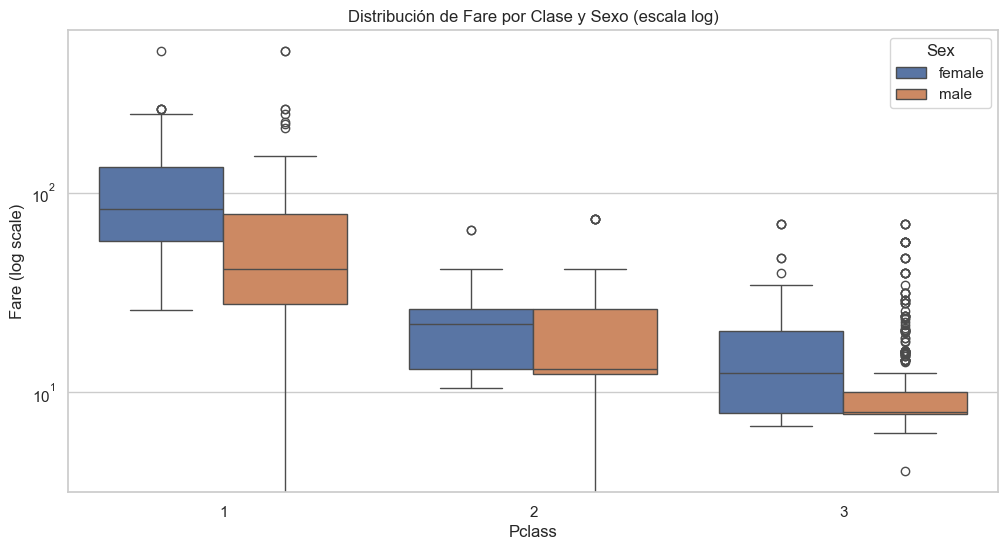

In [58]:
plt.figure(figsize=(12,6))
df_plot = df_clean.copy()
df_plot['Fare_plot'] = df_plot['Fare_pos'].fillna(df_plot['Fare'])
sns.boxplot(data=df_plot, x='Pclass', y='Fare_plot', hue='Sex')
plt.yscale('log')
plt.title('Distribución de Fare por Clase y Sexo (escala log)')
plt.ylabel('Fare (log scale)')
plt.show()

Interpretación:
- La variable `Fare` presenta outliers y mayor dispersión para la primera clase.
- Las comparaciones por sexo dentro de cada clase pueden revelar diferencias de acceso a tickets o combinaciones de reserva.

## Correlaciones y mapa de calor
Calcularemos la matriz de correlación entre variables numéricas y la visualizaremos mediante un heatmap.

In [59]:
num_cols = [c for c in ['Age','Fare','SibSp','Parch','Survived','Pclass'] if c in df_clean.columns]
corr = df_clean[num_cols].corr()
display(corr)

,Age,Fare,SibSp,Parch,Survived,Pclass
Age,1.000000,0.096067,-0.308247,-0.189119,-0.077221,-0.369226
Fare,0.096067,1.000000,0.159651,0.216225,0.257307,-0.549500
SibSp,-0.308247,0.159651,1.000000,0.414838,-0.035322,0.083081
Parch,-0.189119,0.216225,0.414838,1.000000,0.081629,0.018443
Survived,-0.077221,0.257307,-0.035322,0.081629,1.000000,-0.338481
Pclass,-0.369226,-0.549500,0.083081,0.018443,-0.338481,1.000000


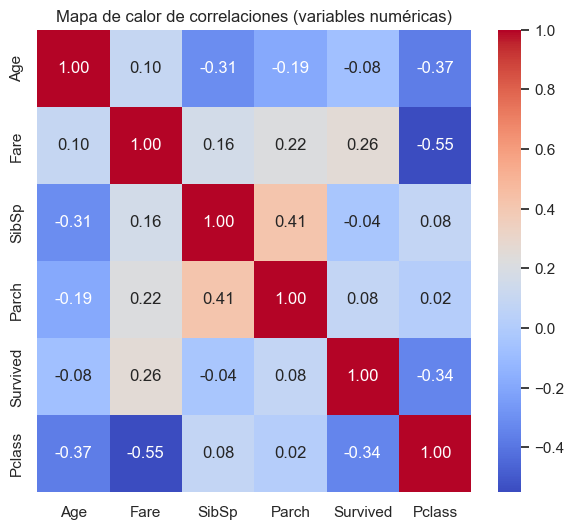

In [60]:
plt.figure(figsize=(7,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Mapa de calor de correlaciones (variables numéricas)')
plt.show()

Interpretación rápida:
- Observa correlaciones con `Survived` para identificar variables con asociación positiva o negativa.
- Recuerda la diferencia entre correlación y causalidad; controlar por `Pclass` y `Sex` en análisis posteriores.

## Scatter plots con línea de tendencia
Mostraremos pares interesantes (Age vs Fare, Fare vs Survived, SibSp vs Parch, Age vs Survived) y el coeficiente r de Pearson.

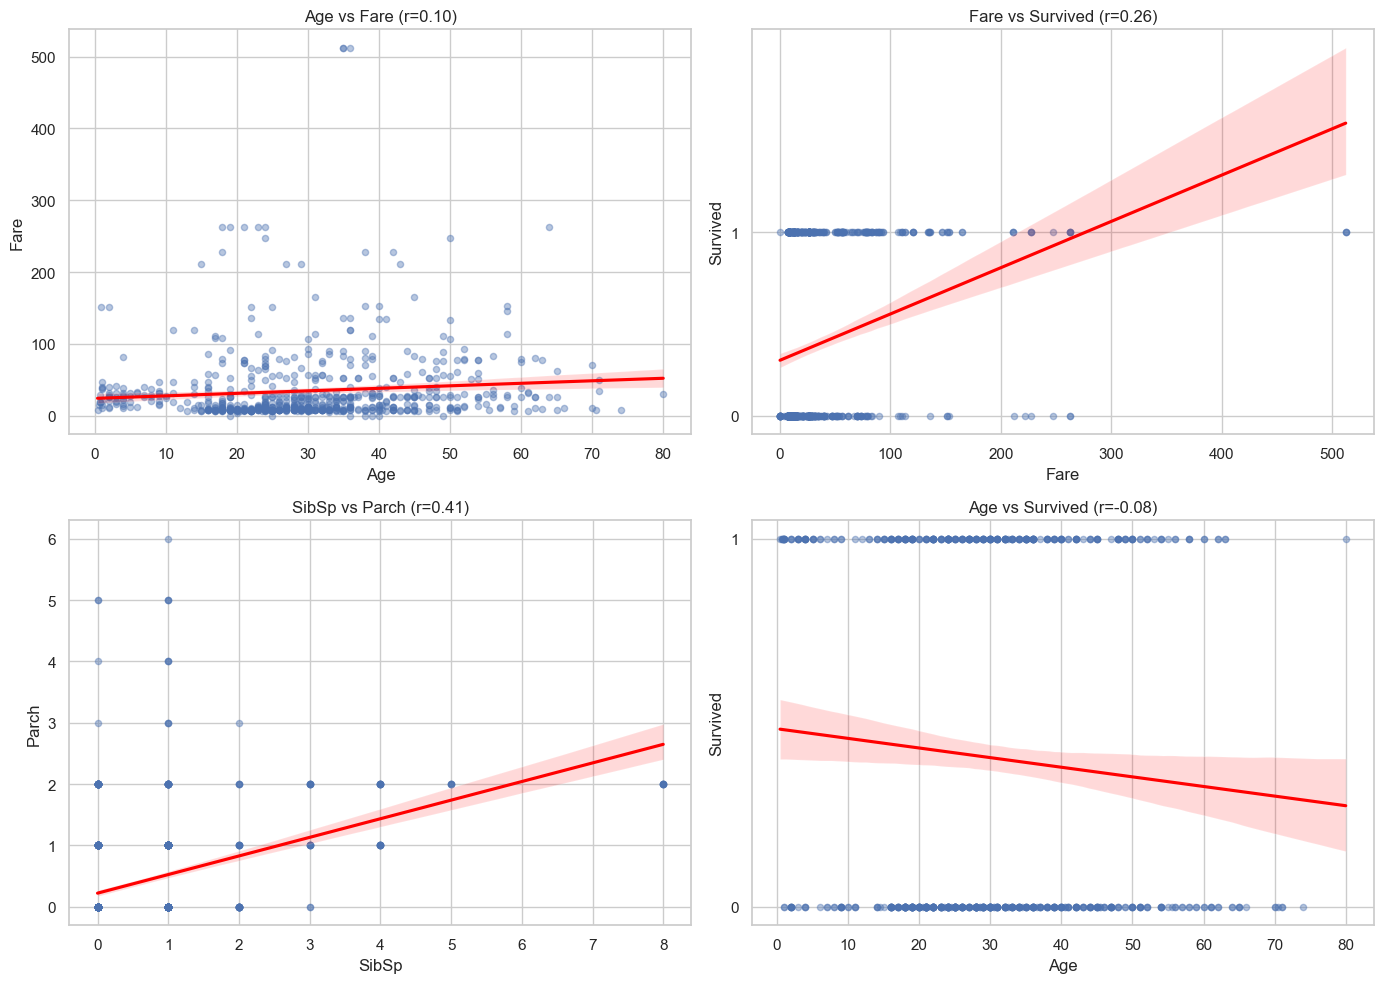

In [61]:
pairs = [('Age','Fare'), ('Fare','Survived'), ('SibSp','Parch'), ('Age','Survived')]
pairs = [p for p in pairs if p[0] in df_clean.columns and p[1] in df_clean.columns]
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
for ax, (x,y) in zip(axes, pairs):
    sub = df_clean[[x,y]].dropna()
    if len(sub) < 2:
        ax.text(0.5,0.5,'Datos insuficientes', ha='center')
        ax.set_axis_off()
        continue
    r = sub[x].corr(sub[y])
    sns.regplot(data=sub, x=x, y=y, ax=ax, scatter_kws={'alpha':0.4,'s':20}, line_kws={'color':'red'})
    ax.set_title(f'{x} vs {y} (r={r:.2f})')
    if x == 'Survived' or y == 'Survived':
        ax.set_yticks([0,1])
plt.tight_layout()
plt.show()

Interpretación:
- `Fare` vs `Survived`: r positiva suele indicar que tarifas mayores se asociaron con mayor supervivencia (efecto de clase).
- `Age` vs `Survived`: revisar estratos por `Pclass` y `Sex` para entender mejor el patrón.

In [64]:
pairs = []
cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        a, b = cols[i], cols[j]
        pairs.append((a, b, corr.loc[a,b]))
pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)
print('Top 5 pares por |r|:')
for a,b,r in pairs_sorted[:5]:
    signo = 'positiva' if r>0 else 'negativa'
    print(f' - {a} vs {b}: r={r:.2f} ({signo})')

# 5 oraciones interpretativas
if pairs_sorted:
    top = pairs_sorted[0]
    print('Cinco oraciones interpretativas:')
    print(f"1) El par con mayor correlación absoluta es {top[0]} vs {top[1]} (r={top[2]:.2f}), indicando una asociación {'positiva' if top[2]>0 else 'negativa' }.")
    influence = {v: sum(abs(corr[v].drop(v))) for v in cols}
    var_most = max(influence.items(), key=lambda x: x[1])
    var_least = min(influence.items(), key=lambda x: x[1])
    print(f"2) La variable más influyente (suma de |r|) es {var_most[0]} con suma={var_most[1]:.2f}.")
    print(f"3) La variable menos correlacionada es {var_least[0]} con suma={var_least[1]:.2f}.")
    if 'Survived' in cols:
        print(f"4) Correlaciones con 'Survived': {[ (c, float(corr.loc['Survived', c])) for c in cols if c!='Survived' ]}")
    print('5) Recordar que correlación no implica causalidad; controlar por Pclass y Sex en análisis posteriores.')

Top 5 pares por |r|:
 - Fare vs Pclass: r=-0.55 (negativa)
 - SibSp vs Parch: r=0.41 (positiva)
 - Age vs Pclass: r=-0.37 (negativa)
 - Survived vs Pclass: r=-0.34 (negativa)
 - Age vs SibSp: r=-0.31 (negativa)
Cinco oraciones interpretativas:
1) El par con mayor correlación absoluta es Fare vs Pclass (r=-0.55), indicando una asociación negativa.
2) La variable más influyente (suma de |r|) es Pclass con suma=1.36.
3) La variable menos correlacionada es Survived con suma=0.79.
4) Correlaciones con 'Survived': [('Age', -0.07722109457217757), ('Fare', 0.25730652238496265), ('SibSp', -0.03532249888573559), ('Parch', 0.08162940708348335), ('Pclass', -0.3384810359610151)]
5) Recordar que correlación no implica causalidad; controlar por Pclass y Sex en análisis posteriores.


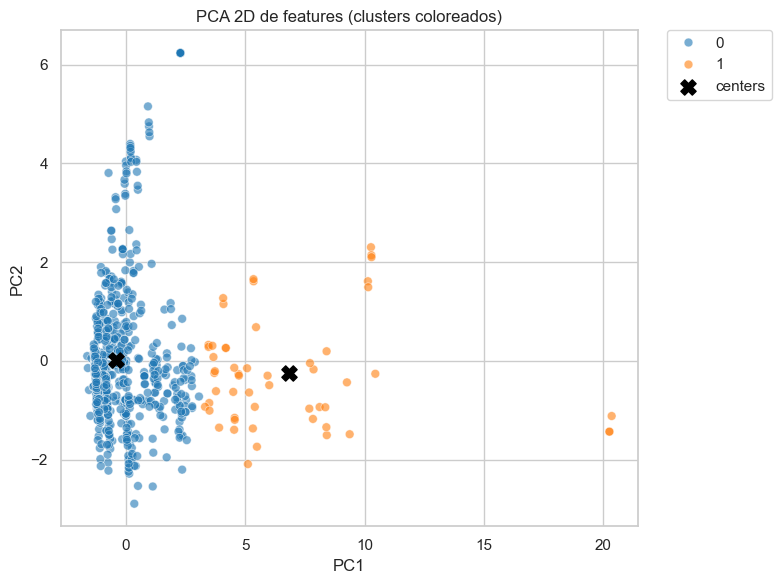

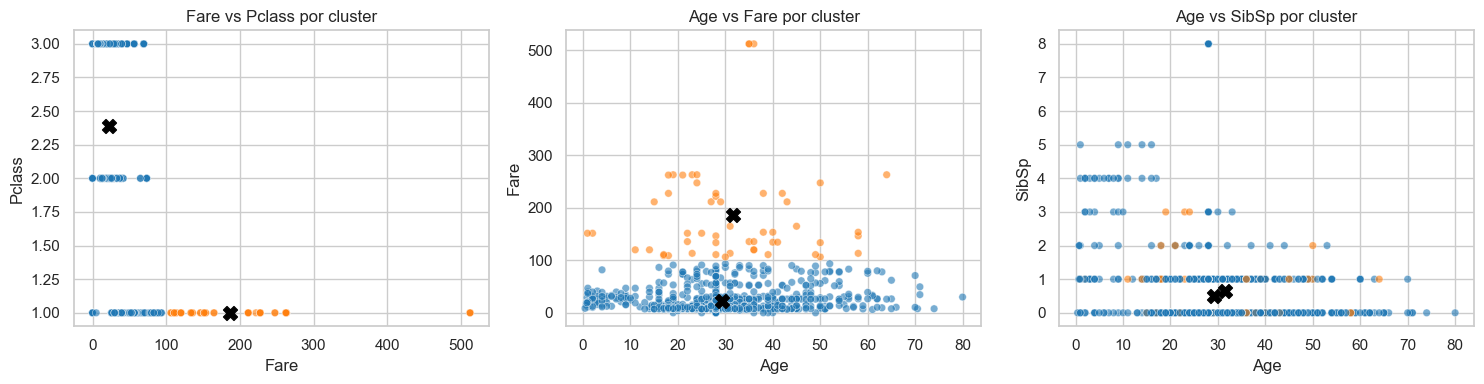

Pclass                     Age                  SibSp               \
             mean median count       mean median count      mean median count   
cluster                                                                         
0        2.391408    3.0   838  29.221062   28.0   838  0.514320    0.0   838   
1        1.000000    1.0    53  31.583396   30.0    53  0.660377    0.0    53   

            Parch                     Fare                
             mean median count        mean  median count  
cluster                                                   
0        0.349642    0.0   838   22.411942   13.00   838  
1        0.886792    1.0    53  187.032858  151.55    53

-> Si quieres, guardo estas figuras en la carpeta del notebook (opcional).


In [65]:
# Visualizaciones por cluster: PCA 2D + pares seleccionados
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Preparar dataframe con etiquetas de cluster (usar variables originales en df_cluster)
df_plot = df_cluster.copy()  # contiene columnas originales seleccionadas
# Asegurar que 'km' y 'centers' existen (resultados del clustering). Si no, lanzar mensaje claro
try:
    labels = km.labels_
    centers_arr = centers  # centros en escala original (como dataframe centers_df)
except NameError:
    raise NameError('Falta ejecutar la sección de k-means antes de las visualizaciones. Ejecuta las celdas de clustering primero.')
df_plot['cluster'] = labels
# PCA para visualizar en 2D (se ajusta sobre X ya escalado)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca['cluster'] = labels
centers_pca = pca.transform(centers_scaled)  # proyectar centros (en espacio escalado)
# Plot PCA 2D
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='tab10', s=40, alpha=0.6)
plt.scatter(centers_pca[:,0], centers_pca[:,1], c='black', s=120, marker='X', label='centers')
plt.title('PCA 2D de features (clusters coloreados)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.show()

# Pares seleccionados: mostrar tres pares interpretables y marcar centros (en escala original)
pairs = [('Fare','Pclass'), ('Age','Fare'), ('Age','SibSp')]
fig, axes = plt.subplots(1, len(pairs), figsize=(5*len(pairs),4))
for ax, (x,y) in zip(axes, pairs):
    sns.scatterplot(data=df_plot, x=x, y=y, hue='cluster', palette='tab10', ax=ax, s=30, alpha=0.6, legend=False)
    # marcar centros
    for i, row in centers_df.iterrows():
        ax.scatter(row[x], row[y], c='black', marker='X', s=100)
    ax.set_title(f'{x} vs {y} por cluster')
plt.tight_layout()
plt.show()

# Tabla resumen: promedio de features por cluster (en escala original)
summary = df_plot.groupby('cluster').agg(['mean','median','count'])[features]
display(summary)
print('-> Si quieres, guardo estas figuras en la carpeta del notebook (opcional).')

## Conclusiones Finales

Se observaron claras diferencias entre las clases (Pclass). La primera clase tiene tarifas más altas y mayores tasas de supervivencia.
La tarifa (Fare) parece relacionarse con la supervivencia, aunque probablemente está influenciada por la clase social.
La edad también varía según la clase y el sexo, y los niños en general tuvieron mejores tasas de supervivencia.

# Hallazgos Principales
Pclass es una de las variables más importantes, ya que afecta tanto el precio del boleto como la probabilidad de sobrevivir.
Fare refleja el nivel socioeconómico y se asocia con la supervivencia, pero no necesariamente de forma directa.
Variables como Age, SibSp y Parch aportan información útil sobre los grupos familiares y deberían considerarse en futuros modelos.

# Limitaciones
Hay datos faltantes, sobre todo en Age y Cabin, que podrían afectar los resultados si no se manejan bien.
Las correlaciones no implican causalidad; algunas relaciones pueden deberse a factores no considerados.
Existen outliers en Fare que conviene analizar antes de seguir con el modelado.

# Recomendaciones
Imputar la edad usando grupos por clase y sexo para reducir sesgos.
Repetir los análisis por grupo (Pclass y Sex) para confirmar los patrones.
Crear nuevas variables como el tamaño familiar o el título (Mr, Mrs, etc.) para mejorar los modelos.
Probar modelos como regresión logística o árboles, usando validación cruzada para comparar resultados.

# Conclusión
En general, las variables más relevantes son Pclass, Fare y Age.
Con una imputación correcta y un análisis más detallado, se pueden construir modelos predictivos más confiables y con mejores resultados.